<a href="https://colab.research.google.com/github/D-kn/Employee-Turnover/blob/main/EmployeeTurnover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

##  Dataset uploading

In [2]:
from google.colab import files

uploaded = files.upload()

Saving Attrition.csv to Attrition (5).csv


In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("Attrition.csv")
df.sample(n=5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1127,23,No,Travel_Rarely,977,Research & Development,10,3,Technical Degree,1,1592,4,Male,45,4,1,Research Scientist,3,Married,2073,12826,2,Y,No,16,3,4,80,1,4,2,3,2,2,2,2
967,40,No,Travel_Rarely,329,Research & Development,1,4,Life Sciences,1,1361,2,Male,88,3,1,Laboratory Technician,2,Married,2387,6762,3,Y,No,22,4,3,80,1,7,3,3,4,2,0,3
324,30,No,Travel_Rarely,1275,Research & Development,28,2,Medical,1,441,4,Female,64,3,2,Research Scientist,4,Married,5775,11934,1,Y,No,13,3,4,80,2,11,2,3,10,8,1,9
480,30,Yes,Travel_Frequently,448,Sales,12,4,Life Sciences,1,648,2,Male,74,2,1,Sales Representative,1,Married,2033,14470,1,Y,No,18,3,3,80,1,1,2,4,1,0,0,0
444,48,No,Travel_Rarely,163,Sales,2,5,Marketing,1,595,2,Female,37,3,2,Sales Executive,4,Married,4051,19658,2,Y,No,14,3,1,80,1,14,2,3,9,7,6,7


## Dataset description

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
df.shape

(1470, 35)

In [6]:
# noumber of unique values 
for col in df.columns:
  n_unique = df[col].nunique()
  if n_unique < 2 :
    print(f"**** {col} column : unique value => {n_unique} ****")
    print()

**** EmployeeCount column : unique value => 1 ****

**** Over18 column : unique value => 1 ****

**** StandardHours column : unique value => 1 ****



**Notes:** In the next step, we can remove from our dataset variables such as "Over18", "EmployeeNumber", "EmployeeCount" because these variables have no particular significance in predicting attrition

# New Dataset for analysis purpose

In [7]:
# delete irrelevant columns
col_drop = ['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'] 

df.drop(col_drop, axis=1, inplace=True)

In [8]:
# Define variable dtypes

num_cols = ['Age', 'DailyRate', 'DistanceFromHome',  'HourlyRate', 'MonthlyIncome','MonthlyRate', 
            'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'TotalWorkingYears', 
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

cat_cols1 = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Attrition']

cat_cols2 = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel','JobSatisfaction', 
             'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']

# Changing dtypes
def dtypes_reformat(df, num_cols, cat_cols1, cat_cols2):
    df_num, df_cat1, df_cat2 = df.loc[:, num_cols], df.loc[:, cat_cols1], df.loc[:, cat_cols2]
    # tranform df_cat2 dtypes to object
    df_cat2[cat_cols2] = df_cat2[cat_cols2].astype(str)
    df_new = pd.concat([df_num, df_cat2, df_cat1], axis=1)
    print(f"'{col_drop[0]}' '{col_drop[1]}' '{col_drop[2]}' and '{col_drop[-1]}' columns removed and the new dataframe shape is : {df_new.shape} ")
    return df_new   

In [9]:
data = dtypes_reformat(df, num_cols, cat_cols1, cat_cols2)

'Over18' 'EmployeeNumber' 'EmployeeCount' and 'StandardHours' columns removed and the new dataframe shape is : (1470, 31) 


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   DailyRate                 1470 non-null   int64 
 2   DistanceFromHome          1470 non-null   int64 
 3   HourlyRate                1470 non-null   int64 
 4   MonthlyIncome             1470 non-null   int64 
 5   MonthlyRate               1470 non-null   int64 
 6   NumCompaniesWorked        1470 non-null   int64 
 7   PercentSalaryHike         1470 non-null   int64 
 8   PerformanceRating         1470 non-null   int64 
 9   TotalWorkingYears         1470 non-null   int64 
 10  YearsAtCompany            1470 non-null   int64 
 11  YearsInCurrentRole        1470 non-null   int64 
 12  YearsSinceLastPromotion   1470 non-null   int64 
 13  YearsWithCurrManager      1470 non-null   int64 
 14  Education               

# Exploration Data Analysis

### Attrition distribution

In [11]:
# Attrition repartition
data["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

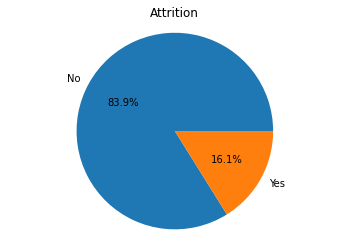

In [12]:
# pie plot
attrition = data["Attrition"].value_counts()
labels = attrition.index
size = attrition.values
plt.pie(size, labels=labels, autopct='%1.1f%%')
plt.title('Attrition')
plt.axis('equal')
plt.show()

## Basic Statistics

In [13]:
desc = data.describe().T.drop("count", axis=1)\
                      .style.background_gradient(
       subset=["mean", "50%"], cmap="Reds"
      )
desc

,mean,std,min,25%,50%,75%,max
Age,36.923810,9.135373,18.000000,30.000000,36.000000,43.000000,60.000000
DailyRate,802.485714,403.509100,102.000000,465.000000,802.000000,1157.000000,1499.000000
DistanceFromHome,9.192517,8.106864,1.000000,2.000000,7.000000,14.000000,29.000000
HourlyRate,65.891156,20.329428,30.000000,48.000000,66.000000,83.750000,100.000000
MonthlyIncome,6502.931293,4707.956783,1009.000000,2911.000000,4919.000000,8379.000000,19999.000000
MonthlyRate,14313.103401,7117.786044,2094.000000,8047.000000,14235.500000,20461.500000,26999.000000
NumCompaniesWorked,2.693197,2.498009,0.000000,1.000000,2.000000,4.000000,9.000000
PercentSalaryHike,15.209524,3.659938,11.000000,12.000000,14.000000,18.000000,25.000000
PerformanceRating,3.153741,0.360824,3.000000,3.000000,3.000000,3.000000,4.000000
TotalWorkingYears,11.279592,7.780782,0.000000,6.000000,10.000000,15.000000,40.000000


### Categorial columns

In [14]:
cat_cols =  [col for col in data.select_dtypes(include='object').columns] 
cat_cols.remove("Attrition")

for col in cat_cols:
  print(f"-- {col} --")
  print(data[col].value_counts(), "\n")
  print("**"*20)

-- Education --
3    572
4    398
2    282
1    170
5     48
Name: Education, dtype: int64 

****************************************
-- EnvironmentSatisfaction --
3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64 

****************************************
-- JobInvolvement --
3    868
2    375
4    144
1     83
Name: JobInvolvement, dtype: int64 

****************************************
-- JobLevel --
1    543
2    534
3    218
4    106
5     69
Name: JobLevel, dtype: int64 

****************************************
-- JobSatisfaction --
4    459
3    442
1    289
2    280
Name: JobSatisfaction, dtype: int64 

****************************************
-- RelationshipSatisfaction --
3    459
4    432
2    303
1    276
Name: RelationshipSatisfaction, dtype: int64 

****************************************
-- StockOptionLevel --
0    631
1    596
2    158
3     85
Name: StockOptionLevel, dtype: int64 

****************************************
-- TrainingTime

In [15]:
for  var in cat_cols:
  d_group =data.groupby(by=[var, "Attrition"]).size().reset_index(name="counts")
  fig = px.bar(d_group,x=var , y= "counts", title = 'Attrition by ' + var , color ="Attrition", barmode='group',  height=500, width=800, text="counts")
  fig.show()

## Numerical variables

### Correlation matrix

Text(0.5, 1.0, 'Pearson correlation maps')

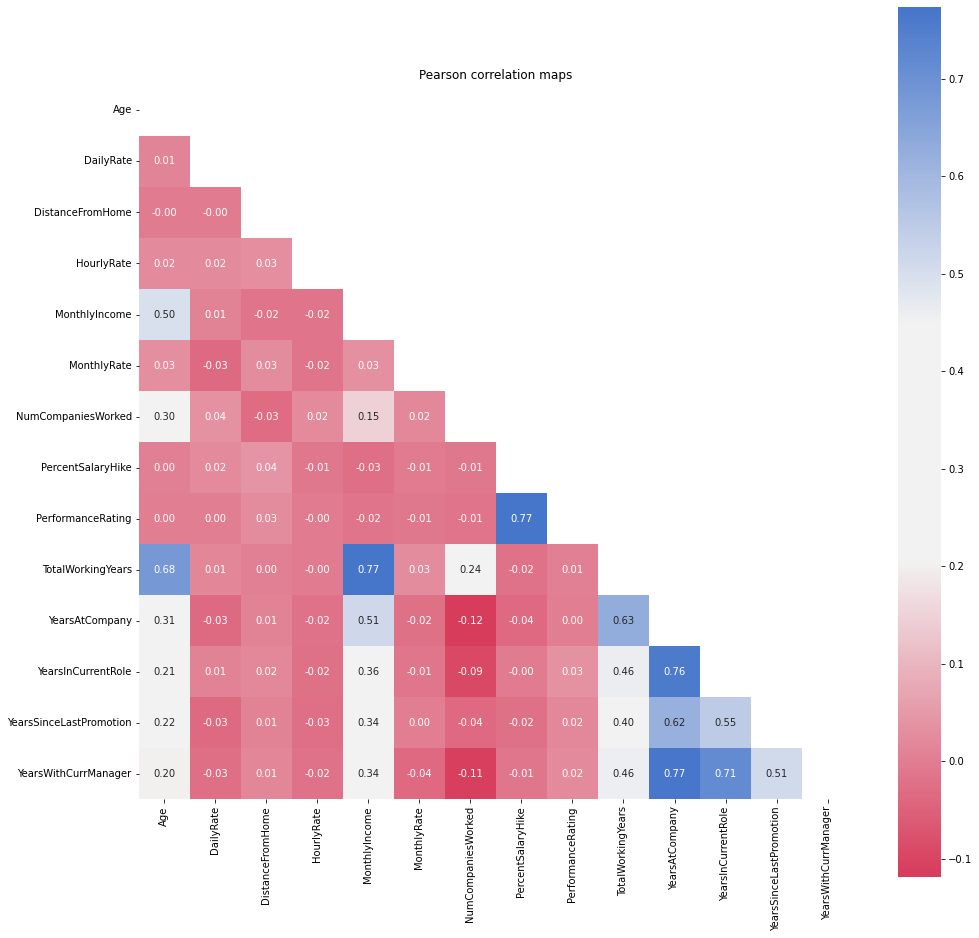

In [16]:
# Create correlation matrix
corr_matrix = data.corr()
# Plot correlation matrix as heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, fmt = ".2f", cmap = sns.diverging_palette(5, 255, sep=70, as_cmap=True), square=True, mask=np.triu(corr_matrix))
plt.title("Pearson correlation maps")

In [17]:
for var in num_cols:
    fig = px.box(data, x='Attrition', y=var, title=var + " vs Attrition", color="Attrition",  height=500, width=800)
    fig.show()

### Working with Age value

Text(0.5, 1.0, 'Gender Monthly income by experience level')

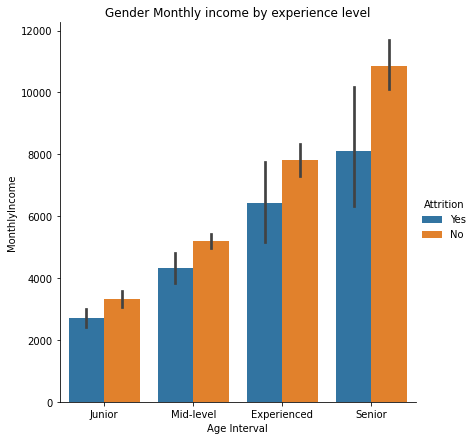

In [18]:
# age intervals list
df_new = data.copy()
age_intervals = [18, 26, 36, 46, 60]

# age interval labels list
age_labels = ['Junior', 'Mid-level', 'Experienced', 'Senior']
new_col = 'Age Interval'

# Use the cut function to create a new column with age intervals
df_new[new_col] = pd.cut(df_new['Age'], bins=age_intervals, labels=age_labels, include_lowest=True)

# # View randomly 10 rows of the dataframe 
# df_new.loc[:, ['Age', new_col]].sample(n=10)
sns.catplot(data=df_new, x=new_col, y="MonthlyIncome", kind='bar', hue='Attrition', height=6)

plt.title('Gender Monthly income by experience level')

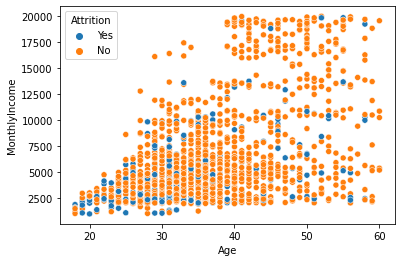

In [19]:
sns.scatterplot(x='Age', y='MonthlyIncome', data=df, hue='Attrition')
plt.show()

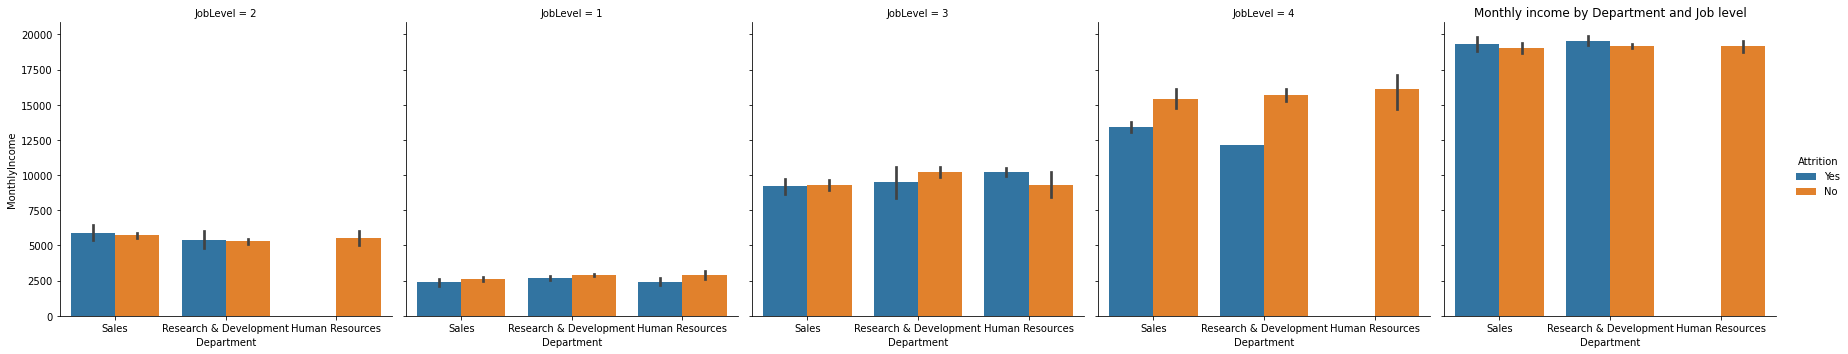

In [20]:
sns.catplot(data=df_new, x='Department', y="MonthlyIncome", kind='bar', col='JobLevel', hue='Attrition')
plt.title('Monthly income by Department and Job level')
plt.show()

## Build Models

### Data transformation

In [24]:
def training_dataset(df, test_size):
  df_m = df.copy()
  # encode target values
  target = 'Attrition'
  df_m[target] = df_m[target].map({'Yes': 1, 'No': 0})
  # df_m = pd.get_dummies(df_m, columns=df_m.select_dtypes(include='object').columns, drop_first=True)
  for cat_col in df_m.select_dtypes(include='object').columns:
    df_m[cat_col] = df_m[cat_col].astype('category').cat.codes
  # split dataset
  X = df_m.drop(target, axis=1)
  y = df_m[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=242, stratify=y)
  print('X train shape : ', X_train.shape)  
  print('X test shape : ', X_test.shape)
  print('y train shape : ', y_train.shape)
  print('y test shape : ', y_test.shape)
  return X_train, X_test, y_train, y_test

### Model training

In [26]:
X_train, X_test, y_train, y_test  = training_dataset(df, test_size=0.3)

X train shape :  (1029, 30)
X test shape :  (441, 30)
y train shape :  (1029,)
y test shape :  (441,)


In [39]:
# def model_training(model, 
#                    param_grid, 
#                    X_train=X_train, 
#                    X_test=X_test, 
#                    y_train=y_train, 
#                    y_test=y_test, 
#                    cv=5
#               ):
#   '''
#   - model : an estimator to be used
#   - param_grid : hyperparameters
#   - cv : fold for cross-validation
#   '''
#   # gird_search object
#   grid_search = GridSearchCV(model, param_grid, cv=cv)
#   # train the GridSearchCV
#   grid_search.fit(X_train, y_train)
#   #use best model for predictions
#   best_ = grid_search.best_estimator_
#   y_pred = best_.predict(X_test)
#   # model accuracy
#   accuracy = accuracy_score(y_test, y_pred)
#   print(f'Accuracy : { round(accuracy*100, 2)} %')
#   print('Best hyperparameters : ', grid_search.best_params_)

#   # feature importance
#   # Get the feature importances
#   importances = best_.feature_importances_

#   # Print the feature importances
#   for feature, importance in zip(X_train.columns, importances):
#       print(f'{feature}: {importance}')


In [40]:
# models = {'svc': SVC(random_state=42), 'rfc': RandomForestClassifier(random_state=42)}

### SVM estimator

### Random Forest estimator

In [42]:
# %%time
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 4, 8]
# }

# # RF = model_training(models['rfc'], param_grid)

In [43]:
%%time
# parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8]
}

# Random Forest classifier instance
rfc = RandomForestClassifier(random_state=42)

# GridSearchCV object 
grid_search = GridSearchCV(rfc, param_grid, cv=5)

# GridSearchCV object training 
grid_search.fit(X_train, y_train)

# Predictions using model 
best_rfc = grid_search.best_estimator_
y_pred = best_rfc.predict(X_test)

# Model accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Best hyperparameters 
print('Best hyperparameters:', grid_search.best_params_)

Accuracy: 0.8684807256235828
Best hyperparameters: {'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 100}


In [65]:
# feature importance
importances = best_rfc.feature_importances_
df_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)
df_importances

,Feature,Importance
15,MonthlyIncome,0.074582
0,Age,0.070994
18,OverTime,0.059778
2,DailyRate,0.057264
23,TotalWorkingYears,0.052435
4,DistanceFromHome,0.051502
16,MonthlyRate,0.051417
9,HourlyRate,0.049662
26,YearsAtCompany,0.048729
29,YearsWithCurrManager,0.034262


Text(0.5, 1.0, 'Random Forest classifier Feature importance')

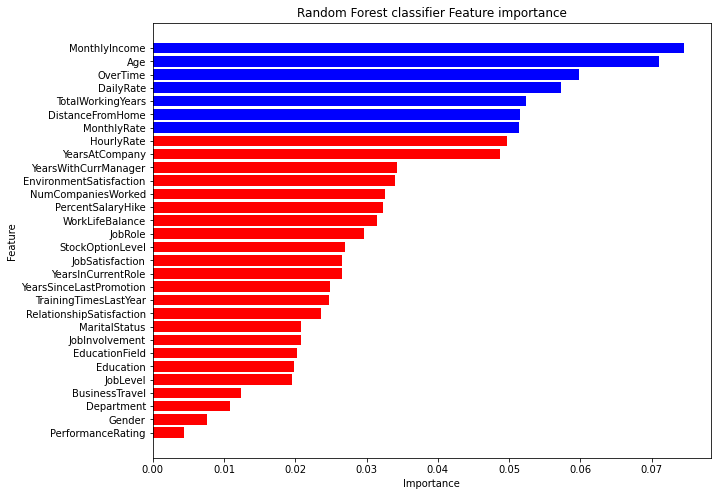

In [68]:
# feature importance plots 
colors = np.where(df_importances['Importance'] >= 0.05, 'b', 'r')

plt.figure(figsize=(10, 8))
df_importances = df_importances.sort_values('Importance')
plt.barh(df_importances['Feature'], df_importances['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest classifier Feature importance')